In [3]:
import os
import pyxdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.decoding import CSP
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix
import os
from mne import Epochs, pick_types, __main__
from mne import Epochs, create_info, events_from_annotations
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, label_binarize


le = LabelEncoder()
import pickle


In [4]:
# === CONFIGURACIÓN ===
base_path = "C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025"
output_file = "EEG_dataset_segmentado.csv"

# === LISTA PARA GUARDAR SEGMENTOS ===
all_segments = []

# === FUNCIÓN PARA CARGAR Y SEGMENTAR ===
def procesar_xdf(ruta, genero, sujeto, tarea):
    data, header = pyxdf.load_xdf(ruta)

    # Identificar flujos
    eeg_stream = next(s for s in data if 'EEG' in s['info']['name'][0])
    marker_stream = next(s for s in data if 'Marker' in s['info']['name'][0] or 'Markers' in s['info']['name'][0])

    # Crear DataFrames
    df_eeg = pd.DataFrame(eeg_stream['time_series'], columns=[f'Ch_{i+1}' for i in range(8)])
    df_eeg['Time_s'] = eeg_stream['time_stamps'] - eeg_stream['time_stamps'][0]

    df_markers = pd.DataFrame({
        'Time_s': marker_stream['time_stamps'] - eeg_stream['time_stamps'][0],
        'Marker': [m[0] for m in marker_stream['time_series']]
    })

    # Buscar pares Start/Stop
    for i in range(len(df_markers) - 1):
        start = df_markers.iloc[i]
        stop = df_markers.iloc[i + 1]

        if "Start" in start["Marker"] and "Stop" in stop["Marker"]:
            # Extraer segmento EEG entre Start y Stop
            segment = df_eeg[(df_eeg['Time_s'] >= start['Time_s']) & (df_eeg['Time_s'] <= stop['Time_s'])].copy()

            # Etiqueta del ensayo
            marker = start["Marker"].lower()

            if "arm" in marker or "hand" in marker:
                segment["Target"] = "Arm"
            elif "leg" in marker or "foot" in marker:
                segment["Target"] = "Leg"
            else:
                segment["Target"] = "Unknown"

            #if "Arm" in start["Marker"]:
               # segment["Target"] = "Arm"
            #elif "Leg" in start["Marker"]:
                #segment["Target"] = "Leg"
            #else:
                #segment["Target"] = "Unknown"

            # Información adicional
            segment["Genero"] = genero
            segment["Sujeto"] = sujeto
            segment["Tarea"] = tarea
            all_segments.append(segment)

# === RECORRER TODAS LAS CARPETAS ===
for genero in ['Female', 'Male']:
    genero_path = os.path.join(base_path, genero)
    for sujeto in os.listdir(genero_path):
        sujeto_path = os.path.join(genero_path, sujeto)
        if os.path.isdir(sujeto_path):
            for tarea in ['AW', 'MI', 'MO']:
                tarea_path = os.path.join(sujeto_path, tarea)
                if os.path.exists(tarea_path):
                    for file in os.listdir(tarea_path):
                        if file.endswith('.xdf'):
                            ruta = os.path.join(tarea_path, file)
                            print(f"Procesando: {ruta}")
                            procesar_xdf(ruta, genero, sujeto, tarea)

# === UNIR TODO Y GUARDAR ===
dataset = pd.concat(all_segments, ignore_index=True)
dataset.to_csv(output_file, index=False)
print(f"\n✅ Base de datos completa guardada en: {output_file}")
print(dataset.head())


Procesando: C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025\Female\1\AW\AW_S01_1.xdf
Procesando: C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025\Female\1\AW\AW_S01_17_R001.xdf
Procesando: C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025\Female\1\AW\AW_S01_2.xdf
Procesando: C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025\Female\1\MI\MI_S01_1.xdf
Procesando: C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025\Female\1\MI\MI_S01_18_R001.xdf
Procesando: C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025\Female\1\MI\MI_S01_2_R001.xdf
Procesando: C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025\Female\1\MI\MI_S01_2_R002.xdf
Procesando: C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025\Female\1\MO\MO_S01_1.xdf
Procesando: C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025\Female\1\MO\MO_S01_2.xdf
Procesando: C:/Users/loper/ITM/automatizac

In [5]:
print(dataset['Target'].value_counts())


Target
Unknown    268398
Leg           119
Arm            99
Name: count, dtype: int64


In [8]:
dataset.head

<bound method NDFrame.head of                  Ch_1           Ch_2           Ch_3           Ch_4  \
0       180467.640625  183620.125000  233836.093750  178049.171875   
1       180439.656250  183591.687500  233822.140625  178022.171875   
2       180403.265625  183529.203125  233718.250000  177976.578125   
3       180417.296875  183535.812500  233709.218750  177989.625000   
4       180456.281250  183593.750000  233812.125000  178035.046875   
...               ...            ...            ...            ...   
268611  177279.828125  193444.875000  210647.234375  141207.953125   
268612  177118.000000  193391.328125  210614.953125  141158.968750   
268613  177091.000000  193399.640625  210624.703125  141171.843750   
268614  177285.906250  193461.953125  210664.312500  141230.671875   
268615  177299.500000  193451.671875  210658.046875  141219.046875   

                 Ch_5           Ch_6           Ch_7           Ch_8  \
0       185340.312500  186361.515625  154884.812500  182792

In [9]:
#valores a conservar
valores_deseados = ['Arm', 'Leg']

#Crear DataFrame con solo las filas que contienen esos valores
dataset_filtrado = dataset[dataset['Target'].isin(valores_deseados)].copy()
print(dataset_filtrado['Target'].value_counts())

Target
Leg    119
Arm     99
Name: count, dtype: int64


In [10]:
ruta = "C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025/EEG_dataset.xlsx"

dataset_filtrado.to_excel(ruta, index=False)

print(f"Archivo guardado en: {ruta}")

Archivo guardado en: C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025/EEG_dataset.xlsx


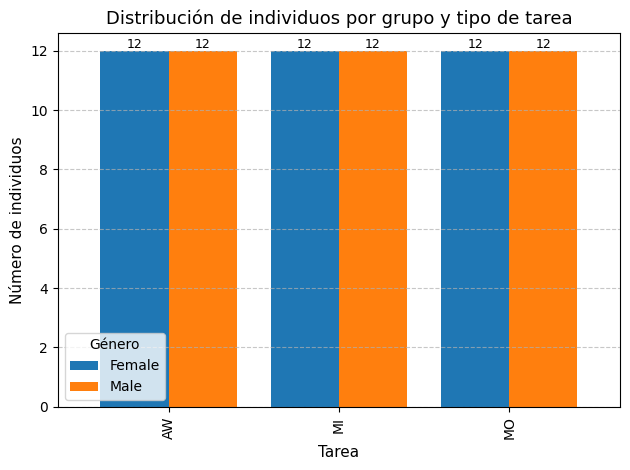

In [11]:
# === Contar sujetos únicos por tarea y género ===
conteo = (
    dataset.groupby(['Tarea', 'Genero'])['Sujeto']
    .nunique()  # 🔹 cuenta sujetos únicos
    .unstack(fill_value=0)
)

# === Crear la gráfica de barras ===
ax = conteo.plot(kind='bar', width=0.8, color=['#1f77b4', '#ff7f0e'])

# === Personalizar ===
plt.title("Distribución de individuos por grupo y tipo de tarea", fontsize=13)
plt.xlabel("Tarea", fontsize=11)
plt.ylabel("Número de individuos", fontsize=11)
plt.legend(title="Género")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar valores sobre las barras
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=9)

plt.tight_layout()
plt.show()


In [12]:
# NECESARIO VER TIPO DE MARCADORES EN SEÑAL
file_path = "C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025/Female/1/AW/AW_S01_1.set"

# Cargar el archivo EEG de EEGLAB
raw = mne.io.read_raw_eeglab(file_path, preload=True)

# Mostrar todas las anotaciones (marcadores) dentro del archivo
print(" Anotaciones encontradas:")
print(raw.annotations)

# Mostrar solo los nombres únicos de los eventos
print("\n Nombres únicos de marcadores:")
print(set(raw.annotations.description))

 Anotaciones encontradas:
<Annotations | 482 segments: Finish_trial (40), Start_beep (40), ...>

 Nombres únicos de marcadores:
{np.str_('Start_fixation_cross_visual'), np.str_('Stop_cue_Leg'), np.str_('Start_experiment_offline'), np.str_('Start_inter_trail'), np.str_('Start_resting'), np.str_('Stop_inter_trail'), np.str_('Finish_trial'), np.str_('Start_trial'), np.str_('Stop_cue_Arm'), np.str_('Start_beep'), np.str_('Stop_experiment_offline'), np.str_('Stop_resting'), np.str_('Stop_fixation_cross_visual'), np.str_('Start_cue_Arm'), np.str_('Start_cue_Leg'), np.str_('Stop_beep')}


In [17]:
# nueva carga datos
ROOT = Path("C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025") 

# Carpetas de géneros y paradigmas que quieres recorrer
GENDERS = ["Female", "Male"]
PARADIGMS = ["AW", "MI", "MO"]

# Mapa electrodo -> nombre de canal en tus datos
CHAN_MAP = {
    "Fz":  "EEG0",
    "C3":  "EEG1",
    "Cz":  "EEG2",
    "C4":  "EEG3",
    "Pz":  "EEG4",
    "PO7": "EEG5",
    "PO8": "EEG6",
    "Oz":  "EEG7",
}

# Canales motores que SÍ queremos usar
MOTOR_ELECS = ["C3", "Cz", "C4", "Pz"]  # puedes quitar Pz si quieres
MOTOR_CHS = [CHAN_MAP[e] for e in MOTOR_ELECS]


# ---------- 1. Cargar archivos ----------

def load_xdf_as_raw(path: Path) -> mne.io.BaseRaw:
    """
    Carga un archivo .xdf usando pyxdf y lo convierte en mne.RawArray.
    Maneja casos donde no existe sampling_rate en metadatos.
    """
    print(f"   [XDF] Cargando con pyxdf: {path}")
    streams, header = pyxdf.load_xdf(str(path))

    if len(streams) == 0:
        raise RuntimeError(f"No se encontraron streams en {path}")

    # Seleccionar stream EEG si existe
    eeg_streams = []
    for s in streams:
        info = s.get("info", {})
        stype = info.get("type", [""])[0] if "type" in info else ""
        if stype.upper() == "EEG":
            eeg_streams.append(s)

    if len(eeg_streams) == 0:
        print("   [XDF] No encontré stream EEG, uso el primero.")
        stream = streams[0]
    else:
        stream = eeg_streams[0]

    data = np.array(stream["time_series"]).T  # (n_channels, n_samples)
    timestamps = np.array(stream["time_stamps"])

    info = stream.get("info", {})

    # ==========================
    # 1. Obtener sampling rate
    # ==========================
    sfreq = None

    # Caso 1: existe sampling_rate en metadatos
    if "sampling_rate" in info:
        try:
            sfreq = float(info["sampling_rate"][0])
        except:
            sfreq = None

    # Caso 2: si sampling_rate es 0 o no existe → calcularlo
    if sfreq is None or sfreq == 0:
        print("   [XDF] sampling_rate NO encontrado, calculando desde timestamps...")
        if len(timestamps) < 2:
            raise ValueError("No hay suficientes timestamps para estimar sampling rate.")

        diffs = np.diff(timestamps)
        median_dt = np.median(diffs)

        if median_dt <= 0:
            raise ValueError("timestamps no válidos para estimar sampling rate.")

        sfreq = 1.0 / median_dt
        print(f"   [XDF] sampling_rate estimado: {sfreq:.2f} Hz")

    # ==========================
    # 2. Obtener nombres de canales
    # ==========================
    ch_names = []
    desc = info.get("desc", [])
    if desc and isinstance(desc[0], dict):
        channels = desc[0].get("channels", [])
        if channels and isinstance(channels[0], dict):
            chans = channels[0].get("channel", [])
            for ch in chans:
                label = ch.get("label", ["Ch"])[0]
                ch_names.append(label)

    # fallback si no vienen nombres
    if not ch_names:
        ch_names = [f"EEG{i}" for i in range(data.shape[0])]

    ch_types = ["eeg"] * len(ch_names)

    mne_info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(data, mne_info)

    print(f"   [XDF] Loaded: {len(ch_names)} canales, sfreq={sfreq:.2f} Hz\n")
    return raw


In [15]:
def load_raw_file(path: Path) -> mne.io.BaseRaw:
    """
    Carga un archivo .set o .xdf y devuelve un Raw de MNE.
    """
    if path.suffix.lower() == ".set":
        print(f"   [SET] Cargando con read_raw_eeglab: {path.name}")
        raw = mne.io.read_raw_eeglab(path, preload=True)
    elif path.suffix.lower() == ".xdf":
        raw = load_xdf_as_raw(path)
    else:
        raise ValueError(f"Extensión no soportada: {path}")
    return raw

In [16]:
# ---------- 2. Filtro pasa banda ----------
def bandpass_filter(raw: mne.io.BaseRaw, l_freq=1.0, h_freq=40.0) -> mne.io.BaseRaw:
    """
    Aplica un filtro pasa banda FIR [l_freq, h_freq].
    """
    raw_filt = raw.copy().filter(
        l_freq=l_freq,
        h_freq=h_freq,
        fir_design="firwin",
    )
    return raw_filt

In [18]:
def pick_motor_channels(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    chs = raw.info["ch_names"]

    # Caso 1: vienen con nombres estándar (C3, Cz, etc.)
    std_names = [c for c in ["C3", "Cz", "C4", "Pz"] if c in chs]
    if std_names:
        return raw.copy().pick_channels(std_names)

    # Caso 2: vienen como EEG0…EEG7
    generic_names = [c for c in MOTOR_CHS if c in chs]
    if generic_names:
        return raw.copy().pick_channels(generic_names)

    # Fallback: si algo raro pasa, usamos todos
    print("[WARN] No encontré canales motores claros, usando todos.")
    return raw.copy()


In [19]:
def compute_bandpower_features(raw, bands=None):
    if bands is None:
        bands = {
            "delta": (1, 4),
            "theta": (4, 8),
            "alpha": (8, 13),
            "beta":  (13, 30),
        }

    n_times = raw.n_times
    n_fft = min(1024, int(n_times))

    psd_obj = raw.compute_psd(
        method="welch",
        fmin=1,
        fmax=40,
        n_fft=n_fft,
    )
    psd = psd_obj.get_data()
    freqs = psd_obj.freqs

    psd_mean = psd.mean(axis=0)  # media sobre canales

    feats = {}
    for name, (fmin, fmax) in bands.items():
        idx = (freqs >= fmin) & (freqs < fmax)
        feats[f"bp_{name}"] = psd_mean[idx].mean()
    return feats


def compute_psd_features(raw, fmin=1, fmax=40):
    n_times = raw.n_times
    n_fft = min(1024, int(n_times))

    psd_obj = raw.compute_psd(
        method="welch",
        fmin=fmin,
        fmax=fmax,
        n_fft=n_fft,
    )
    psd = psd_obj.get_data()
    psd_db = 10 * np.log10(psd + 1e-12)

    flat = psd_db.reshape(-1)
    feats = {f"psd_{i}": v for i, v in enumerate(flat)}
    return feats


In [20]:
def collect_epochs_for_subject_paradigm(subject_dir: Path,
                                        gender: str,
                                        paradigm: str):
    epoch_data = []        # np.array por época (n_ch, n_times)
    labels = []            # 1 Arm, 0 Leg
    meta_list = []         # dicts de metadatos
    feat_bp_psd_list = []  # dicts con BP+PSD

    if not subject_dir.exists():
        return None, None, [], []

    parad_dir = subject_dir / paradigm
    if not parad_dir.exists():
        return None, None, [], []

    files = [f for f in parad_dir.iterdir()
             if f.suffix.lower() in (".set", ".xdf")]

    for f in sorted(files):
        print(f"   [{paradigm}] procesando archivo {f.name}")
        raw = load_raw_file(f)          # tu función
        raw = pick_motor_channels(raw)  # SOLO C3, Cz, C4, Pz
        raw = bandpass_filter(raw, l_freq=8.0, h_freq=30.0)  # filtro MI típico

        if raw.annotations is None or len(raw.annotations) == 0:
            print("      [WARN] sin anotaciones, salto archivo.")
            continue

        events, event_id = mne.events_from_annotations(raw)

        arm_ids = []
        leg_ids = []
        for desc, code in event_id.items():
            d = desc.lower()
            if "arm" in d or "superior" in d:
                arm_ids.append(code)
            elif "leg" in d or "inferior" in d:
                leg_ids.append(code)

        if not arm_ids and not leg_ids:
            print("      [WARN] no encontré eventos Arm/Leg en anotaciones.")
            continue

        tmin, tmax = 0.5, 2.5  # ventana después del cue (ajusta según tu protocolo)

        # ARM
        if arm_ids:
            event_id_arm = {f"Arm_{code}": code for code in arm_ids}
            epochs_arm = mne.Epochs(raw, events, event_id_arm,
                                    tmin=tmin, tmax=tmax,
                                    baseline=None, preload=True)
            data_arm = epochs_arm.get_data()
            for i, ep in enumerate(data_arm):
                ep_raw = mne.io.RawArray(ep, raw.info.copy())
                bp_feats = compute_bandpower_features(ep_raw)
                psd_feats = compute_psd_features(ep_raw)

                epoch_data.append(ep)
                labels.append(1)  # Arm

                meta_list.append({
                    "gender": gender,
                    "subject": subject_dir.name,
                    "paradigm": paradigm,
                    "file": f.name,
                    "epoch_idx": i,
                    "target": "Arm",
                })
                feat = {}
                feat.update(bp_feats)
                feat.update(psd_feats)
                feat_bp_psd_list.append(feat)

        # LEG
        if leg_ids:
            event_id_leg = {f"Leg_{code}": code for code in leg_ids}
            epochs_leg = mne.Epochs(raw, events, event_id_leg,
                                    tmin=tmin, tmax=tmax,
                                    baseline=None, preload=True)
            data_leg = epochs_leg.get_data()
            for i, ep in enumerate(data_leg):
                ep_raw = mne.io.RawArray(ep, raw.info.copy())
                bp_feats = compute_bandpower_features(ep_raw)
                psd_feats = compute_psd_features(ep_raw)

                epoch_data.append(ep)
                labels.append(0)  # Leg

                meta_list.append({
                    "gender": gender,
                    "subject": subject_dir.name,
                    "paradigm": paradigm,
                    "file": f.name,
                    "epoch_idx": i,
                    "target": "Leg",
                })
                feat = {}
                feat.update(bp_feats)
                feat.update(psd_feats)
                feat_bp_psd_list.append(feat)

    if not epoch_data:
        return None, None, [], []

    X_all = np.stack(epoch_data)  # (n_epochs, n_ch, n_times)
    y_all = np.array(labels)
    return X_all, y_all, meta_list, feat_bp_psd_list


In [21]:
def build_feature_database():
    rows = []

    for gender in GENDERS:
        gender_dir = ROOT / gender
        if not gender_dir.exists():
            continue

        for subject_dir in sorted(gender_dir.iterdir()):
            if not subject_dir.is_dir():
                continue

            subject_id = subject_dir.name
            print(f"\n=== Sujeto {gender}/{subject_id} ===")

            for paradigm in PARADIGMS:
                print(f" -> Paradigma: {paradigm}")
                X_all, y_all, meta_list, feat_bp_psd_list = \
                    collect_epochs_for_subject_paradigm(
                        subject_dir, gender, paradigm
                    )

                if X_all is None:
                    print("    (sin datos Arm/Leg en este paradigma)")
                    continue

                print(f"    n_epochs = {len(y_all)}")

                # CSP Arm vs Leg
                csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
                X_csp = csp.fit_transform(X_all, y_all)  # (n_epochs, n_comp)

                # Construir filas finales
                for i in range(len(y_all)):
                    row = {}
                    row.update(meta_list[i])
                    row.update(feat_bp_psd_list[i])

                    for j, val in enumerate(X_csp[i]):
                        row[f"CSP_comp{j}"] = val

                    rows.append(row)

    df = pd.DataFrame(rows)
    out_path = ROOT / "features_BP_PSD_CSP_motores.xlsx"
    df.to_excel(out_path, index=False)
    print(f"\n>>> Base de datos guardada en: {out_path}")
    return df


In [22]:
if __name__ == "__main__":
    df = build_feature_database()
    print(df.head())



=== Sujeto Female/1 ===
 -> Paradigma: AW
   [AW] procesando archivo AW_S01_1.set
   [SET] Cargando con read_raw_eeglab: AW_S01_1.set
[WARN] No encontré canales motores claros, usando todos.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)

Used Annotations descriptions: [np.str_('Finish_trial'), np.str_('Start_beep'), np.str_('Start_cue_Arm'), np.str_('Start_cue_Leg'), np.str_('Start_experiment_offline'), np.str_('Start_fixation_cross_visual'), np.str_('Start_inter_trail'), np.str_('

In [91]:
df.head

<bound method NDFrame.head of        gender subject paradigm          file event_type  epoch_idx target  \
0      Female       1       AW  AW_S01_1.set        Arm          0    Arm   
1      Female       1       AW  AW_S01_1.set        Arm          1    Arm   
2      Female       1       AW  AW_S01_1.set        Arm          2    Arm   
3      Female       1       AW  AW_S01_1.set        Arm          3    Arm   
4      Female       1       AW  AW_S01_1.set        Arm          4    Arm   
...       ...     ...      ...           ...        ...        ...    ...   
11331    Male       7       MO  MO_S07_2.set        Leg         35    Leg   
11332    Male       7       MO  MO_S07_2.set        Leg         36    Leg   
11333    Male       7       MO  MO_S07_2.set        Leg         37    Leg   
11334    Male       7       MO  MO_S07_2.set        Leg         38    Leg   
11335    Male       7       MO  MO_S07_2.set        Leg         39    Leg   

          bp_delta    bp_theta   bp_alpha  ..

In [24]:
df.to_excel(ROOT / "features_BP_PSD_CSP_TARGET(canales).xlsx", index=False)


In [30]:
df = pd.read_excel("C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025/features_BP_PSD_CSP_TARGET(canales).xlsx")


In [31]:
df.describe()

subject     epoch_idx      bp_delta      bp_theta      bp_alpha  \
count  11336.000000  11336.000000  11336.000000  11336.000000  11336.000000   
mean      14.294284     19.458716      0.031137     21.797906     28.929126   
std        8.136670     11.521157      1.294373    462.533141    517.811899   
min        1.000000      0.000000      0.000024      0.057166      0.299658   
25%        7.000000      9.000000      0.000172      0.416401      1.401896   
50%       14.500000     19.000000      0.000356      0.755530      2.514282   
75%       20.000000     29.000000      0.001127      1.640300      5.193202   
max       29.000000     39.000000    110.964424  32676.894775  37532.240318   

            bp_beta         psd_0         psd_1         psd_2         psd_3  \
count  11336.000000  11336.000000  11336.000000  11336.000000  11336.000000   
mean      17.749751    -33.609406    -33.912494    -34.644337    -35.096863   
std       96.337691      8.940881      8.904890      8.730795      8.563722   
min        0.160955    -77.225224    -81.563678    -87.876865    -73.381531   
25%        0.576907    -38.836915    -39.248011    -39.766338    -40.118913   
50%        0.977443    -33.994006    -34.172608    -34.970907    -35.399171   
75%        1.942328    -29.182078    -29.485745    -30.310491    -30.970333   
max     5046.461051     11.049483      6.302359      7.198301      6.029399   

       ...       psd_618       psd_619       psd_620       psd_621  \
count  ...  11336.000000  11336.000000  11336.000000  11336.000000   
mean   ...    -42.501428    -44.316287    -44.580702    -45.026861   
std    ...      7.601397      7.815602      7.797679      7.838793   
min    ...    -85.695920    -87.857642    -78.020247   -106.498875   
25%    ...    -47.158662    -48.974462    -49.287277    -49.713764   
50%    ...    -42.462247    -44.159787    -44.368757    -44.870644   
75%    ...    -37.728095    -39.477702    -39.752243    -40.165741   
max    ...      3.516434      3.013944      3.164015      2.841411   

            psd_622       psd_623     CSP_comp0     CSP_comp1     CSP_comp2  \
count  11336.000000  11336.000000  11336.000000  11336.000000  11336.000000   
mean     -45.427298    -45.774225     -2.277863     -1.662675     -1.364942   
std        7.867750      7.929752      1.523183      1.272609      1.086214   
min      -90.152783    -90.590156     -7.572426     -6.366967     -4.561757   
25%      -50.197714    -50.448113     -3.077143     -2.251365     -1.839215   
50%      -45.260974    -45.608060     -2.110105     -1.425269     -1.174810   
75%      -40.586495    -40.846633     -1.332683     -0.960748     -0.762160   
max        2.815852      2.678440      4.376841      4.333476      4.301239   

          CSP_comp3  
count  11336.000000  
mean      -1.130375  
std        0.843868  
min       -4.368727  
25%       -1.529393  
50%       -1.026999  
75%       -0.693941  
max        3.824454  

[8 rows x 634 columns]

In [35]:
def reduce_psd_to_bands(df):
    freq_res = 1  # según tu PSD
    
    # bandas típicas MI
    bands = {
        "psd_delta": (1, 4),
        "psd_theta": (4, 8),
        "psd_alpha": (8, 13),
        "psd_beta":  (13, 30),
    }

    psd_cols = [c for c in df.columns if c.startswith("psd_")]
    psd_vals = df[psd_cols].values

    # reconstruir frecuencias
    n_psd = len(psd_cols)
    freqs = np.linspace(1, 40, n_psd)

    new_feats = {}
    for name, (fmin, fmax) in bands.items():
        mask = (freqs >= fmin) & (freqs < fmax)
        new_feats[name] = psd_vals[:, mask].mean(axis=1)

    for key in new_feats:
        df[key] = new_feats[key]

    df = df.drop(columns=psd_cols)
    return df


In [27]:
from sklearn.decomposition import PCA

# seleccionar solo PSD
psd_cols = [c for c in df.columns if c.startswith("psd_")]
X_psd = df[psd_cols].values

# PCA a 20 componentes
pca = PCA(n_components=20)
X_psd_20 = pca.fit_transform(X_psd)

# añadir PCA al dataframe
for i in range(X_psd_20.shape[1]):
    df[f"psd_pca_{i}"] = X_psd_20[:, i]

# eliminar PSD original
df = df.drop(columns=psd_cols)


In [34]:
df.info

<bound method DataFrame.info of        gender  subject paradigm          file  epoch_idx target  bp_delta  \
0      Female        1       AW  AW_S01_1.set          0    Arm  0.001197   
1      Female        1       AW  AW_S01_1.set          1    Arm  0.000574   
2      Female        1       AW  AW_S01_1.set          2    Arm  0.008289   
3      Female        1       AW  AW_S01_1.set          3    Arm  0.003392   
4      Female        1       AW  AW_S01_1.set          4    Arm  0.001167   
...       ...      ...      ...           ...        ...    ...       ...   
11331    Male        7       MO  MO_S07_2.set         35    Leg  0.000550   
11332    Male        7       MO  MO_S07_2.set         36    Leg  0.000167   
11333    Male        7       MO  MO_S07_2.set         37    Leg  0.000578   
11334    Male        7       MO  MO_S07_2.set         38    Leg  0.000174   
11335    Male        7       MO  MO_S07_2.set         39    Leg  0.000710   

       bp_theta   bp_alpha   bp_beta  ...  

In [36]:
df = reduce_psd_to_bands(df)
print(df.columns)
print(df.shape)

Index(['gender', 'subject', 'paradigm', 'file', 'epoch_idx', 'target',
       'bp_delta', 'bp_theta', 'bp_alpha', 'bp_beta', 'CSP_comp0', 'CSP_comp1',
       'CSP_comp2', 'CSP_comp3', 'psd_delta', 'psd_theta', 'psd_alpha',
       'psd_beta'],
      dtype='object')
(11336, 18)


In [37]:
# eliminar columnas que no aportan al entrenamiento del modelo
cols_to_drop = ["gender", "subject", "file", "epoch_idx"]

df_clean = df.drop(columns=cols_to_drop)

In [38]:
#convertir dataset a binario con Arm=1/leg=0
df_clean["target_bin"] = df_clean["target"].map({"Arm": 1, "Leg": 0})


In [39]:
#eliminar target original
df_clean = df_clean.drop(columns=["target"])


In [40]:
#verificar estado df
print(df_clean.head())
print(df_clean["target_bin"].value_counts())


  paradigm  bp_delta  bp_theta   bp_alpha   bp_beta  CSP_comp0  CSP_comp1  \
0       AW  0.001197  1.262793   3.335057  1.681043  -2.544857  -3.357148   
1       AW  0.000574  0.840236   5.858278  1.290530  -2.005458  -3.508417   
2       AW  0.008289  6.105481   4.625830  1.649255  -2.402431  -3.619306   
3       AW  0.003392  4.164175  23.611868  2.758816  -2.418193  -2.746128   
4       AW  0.001167  4.017423   9.926421  1.967471  -2.166604  -2.396415   

   CSP_comp2  CSP_comp3  psd_delta  psd_theta  psd_alpha   psd_beta  \
0  -1.711959  -1.299716  -4.956678 -11.623835  -8.755919 -10.253562   
1  -1.796155  -1.169081  -5.820397 -12.969761 -10.627274 -11.458261   
2  -0.325428  -1.093415  -3.014503  -9.021758  -7.111729  -7.109124   
3  -0.677714  -0.756963  -1.244849  -7.198782  -6.189230  -6.055402   
4  -0.793057  -0.281775  -3.875961  -9.459987  -8.726723  -8.622739   

   target_bin  
0           1  
1           1  
2           1  
3           1  
4           1  
target_bin
1  

In [43]:
df_clean

paradigm  bp_delta  bp_theta   bp_alpha   bp_beta  CSP_comp0  CSP_comp1  \
0           AW  0.001197  1.262793   3.335057  1.681043  -2.544857  -3.357148   
1           AW  0.000574  0.840236   5.858278  1.290530  -2.005458  -3.508417   
2           AW  0.008289  6.105481   4.625830  1.649255  -2.402431  -3.619306   
3           AW  0.003392  4.164175  23.611868  2.758816  -2.418193  -2.746128   
4           AW  0.001167  4.017423   9.926421  1.967471  -2.166604  -2.396415   
...        ...       ...       ...        ...       ...        ...        ...   
11331       MO  0.000550  1.253960  11.783639  0.617303  -1.174446  -1.365143   
11332       MO  0.000167  0.313949   2.339126  0.651936  -1.666465  -1.467178   
11333       MO  0.000578  0.930173   4.542231  0.550037  -0.826596  -1.291455   
11334       MO  0.000174  0.608212   1.686864  0.605335  -1.975084  -1.876044   
11335       MO  0.000710  0.673597   2.674535  0.592692  -1.304403  -1.802671   

       CSP_comp2  CSP_comp3  psd_delta  psd_theta  psd_alpha   psd_beta  \
0      -1.711959  -1.299716  -4.956678 -11.623835  -8.755919 -10.253562   
1      -1.796155  -1.169081  -5.820397 -12.969761 -10.627274 -11.458261   
2      -0.325428  -1.093415  -3.014503  -9.021758  -7.111729  -7.109124   
3      -0.677714  -0.756963  -1.244849  -7.198782  -6.189230  -6.055402   
4      -0.793057  -0.281775  -3.875961  -9.459987  -8.726723  -8.622739   
...          ...        ...        ...        ...        ...        ...   
11331  -0.980053  -1.000637  -6.665803 -13.343138 -11.763852 -11.925818   
11332  -1.666353  -0.908117  -9.530646 -16.335810 -13.548647 -13.292558   
11333  -1.122283  -0.348138  -7.638134 -14.608800 -12.441994 -13.708394   
11334  -1.837135  -1.167884 -10.650819 -13.996586 -12.574813 -13.273852   
11335  -0.834499  -1.238514  -8.647554 -13.666803 -12.022638 -12.469387   

       target_bin  
0               1  
1               1  
2               1  
3               1  
4               1  
...           ...  
11331           0  
11332           0  
11333           0  
11334           0  
11335           0  

[11336 rows x 14 columns]

In [44]:
df_AW = df_clean[df_clean["paradigm"] == "AW"]
df_MI = df_clean[df_clean["paradigm"] == "MI"]
df_MO = df_clean[df_clean["paradigm"] == "MO"]


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def train_svm_and_evaluate(df_paradigm, show_matrix=True):

    # X = todas las columnas numéricas excepto target_bin y paradigm
    drop_cols = ["paradigm", "target_bin"]
    X = df_paradigm.drop(columns=drop_cols)
    y = df_paradigm["target_bin"]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=None, stratify=y
    )

    # Modelo SVM
    clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=10, gamma="scale"))
    ])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Métricas
    print("\n============================================")
    print("Paradigma:", df_paradigm["paradigm"].iloc[0])
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    if show_matrix:
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=["Leg (0)", "Arm (1)"],
                    yticklabels=["Leg (0)", "Arm (1)"])
        plt.xlabel("Predicción")
        plt.ylabel("Real")
        plt.title(f"Matriz de Confusión - {df_paradigm['paradigm'].iloc[0]}")
        plt.show()

    return clf



Paradigma: AW
Accuracy: 0.5093085106382979
              precision    recall  f1-score   support

           0       0.51      0.59      0.54       376
           1       0.51      0.43      0.47       376

    accuracy                           0.51       752
   macro avg       0.51      0.51      0.51       752
weighted avg       0.51      0.51      0.51       752



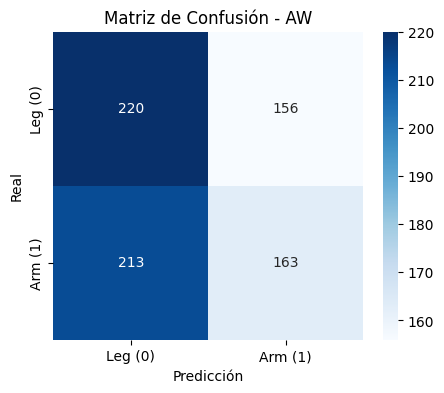


Paradigma: MI
Accuracy: 0.49867021276595747
              precision    recall  f1-score   support

           0       0.50      0.47      0.48       376
           1       0.50      0.53      0.51       376

    accuracy                           0.50       752
   macro avg       0.50      0.50      0.50       752
weighted avg       0.50      0.50      0.50       752



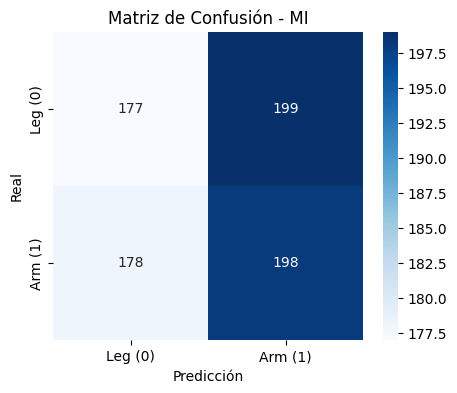


Paradigma: MO
Accuracy: 0.5091623036649214
              precision    recall  f1-score   support

           0       0.51      0.54      0.52       380
           1       0.51      0.47      0.49       384

    accuracy                           0.51       764
   macro avg       0.51      0.51      0.51       764
weighted avg       0.51      0.51      0.51       764



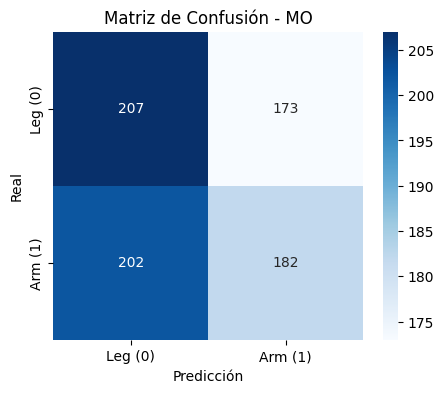

In [53]:
model_AW = train_svm_and_evaluate(df_AW)
model_MI = train_svm_and_evaluate(df_MI)
model_MO = train_svm_and_evaluate(df_MO)


In [12]:
from pathlib import Path

raw = load_raw_file(Path("C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025/Female/10/AW/AW_S010_1.xdf"))
print(raw.info["ch_names"])


   [XDF] Cargando con pyxdf: C:\Users\loper\ITM\automatización\auto 2\BCI\OneDrive_1_18-10-2025\Female\10\AW\AW_S010_1.xdf
   [XDF] sampling_rate NO encontrado, calculando desde timestamps...
   [XDF] sampling_rate estimado: 249.90 Hz
Creating RawArray with float64 data, n_channels=8, n_times=102831
    Range : 0 ... 102830 =      0.000 ...   411.492 secs
Ready.
   [XDF] Loaded: 8 canales, sfreq=249.90 Hz

['EEG0', 'EEG1', 'EEG2', 'EEG3', 'EEG4', 'EEG5', 'EEG6', 'EEG7']


In [47]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = Pipeline([
    ("csp", CSP(n_components=6, reg=None, log=True)),
    ("lda", LDA())
])


In [65]:
import numpy as np
df_MI = df_MI.drop(columns=["paradigm"])

X = df_MI.drop(columns=["target_bin"]).values
y = df_MI["target_bin"].values


In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)


In [85]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

cla = LDA()
cla.fit(X_train, y_train)

y_pred = cla.predict(X_test)



PARADIGMA: MI

Accuracy: 0.5212765957446809

Reporte:
              precision    recall  f1-score   support

           0       0.53      0.44      0.48       376
           1       0.52      0.61      0.56       376

    accuracy                           0.52       752
   macro avg       0.52      0.52      0.52       752
weighted avg       0.52      0.52      0.52       752



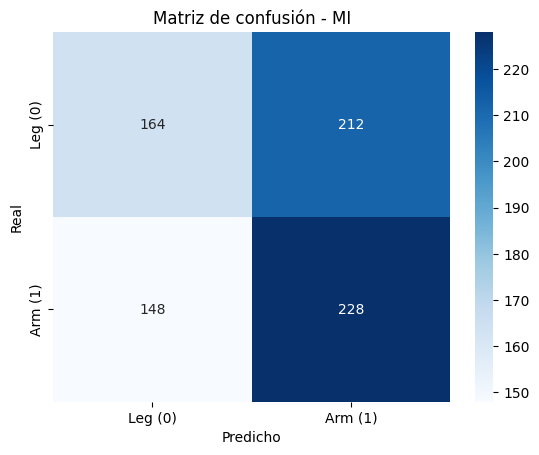



PARADIGMA: AW

Accuracy: 0.5093085106382979

Reporte:
              precision    recall  f1-score   support

           0       0.51      0.46      0.48       376
           1       0.51      0.56      0.53       376

    accuracy                           0.51       752
   macro avg       0.51      0.51      0.51       752
weighted avg       0.51      0.51      0.51       752



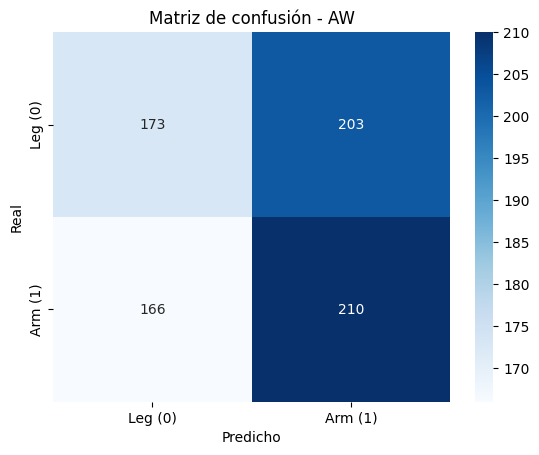



PARADIGMA: MO

Accuracy: 0.5143979057591623

Reporte:
              precision    recall  f1-score   support

           0       0.51      0.49      0.50       380
           1       0.52      0.54      0.53       384

    accuracy                           0.51       764
   macro avg       0.51      0.51      0.51       764
weighted avg       0.51      0.51      0.51       764



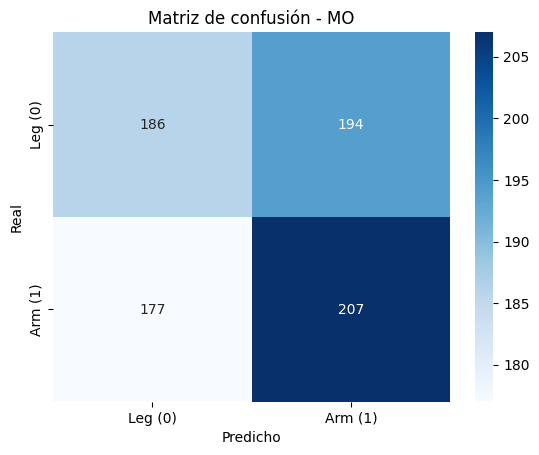

In [89]:

# Función para entrenar un paradigma
def train_for_paradigm(df, paradigm_name):
    print(f"\n\n===========================\nPARADIGMA: {paradigm_name}\n===========================")

    df_p = df_clean[df_clean["paradigm"] == paradigm_name]

    if df_p.empty:
        print("No hay datos para este paradigma.")
        return

    # Quitar columna no numérica
    df_p = df_p.drop(columns=["paradigm"])

    # Separar X y y
    X = df_p.drop(columns=["target_bin"]).values
    y = df_p["target_bin"].values

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # LDA
    lda = LDA()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)

    print("\nAccuracy:", accuracy_score(y_test, y_pred))
    print("\nReporte:")
    print(classification_report(y_test, y_pred))

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Leg (0)", "Arm (1)"],
                yticklabels=["Leg (0)", "Arm (1)"])
    plt.title(f"Matriz de confusión - {paradigm_name}")
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.show()


# Entrenar para MI, AW y MO
train_for_paradigm(df, "MI")
train_for_paradigm(df, "AW")
train_for_paradigm(df, "MO")

In [90]:
df_clean.to_excel(ROOT / "features_BP_PSD_CSP_TARGET(canales filtrados).xlsx", index=False)


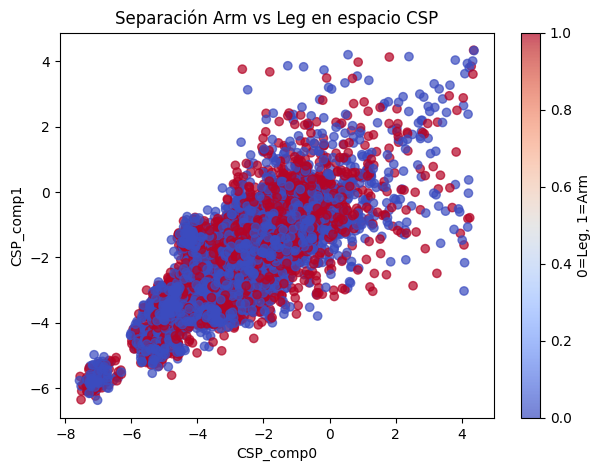

In [91]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.scatter(df["CSP_comp0"], df["CSP_comp1"],
            c=df["target_bin"], cmap="coolwarm", alpha=0.7)
plt.xlabel("CSP_comp0")
plt.ylabel("CSP_comp1")
plt.title("Separación Arm vs Leg en espacio CSP")
plt.colorbar(label="0=Leg, 1=Arm")
plt.show()


C:\Users\loper\AppData\Local\Temp\ipykernel_4392\1918687650.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["target_bin"], y=df[col], palette="coolwarm")


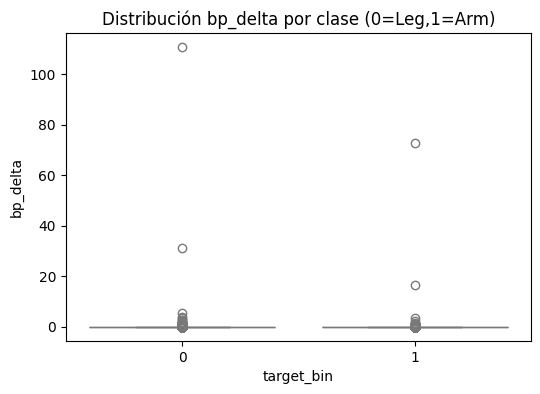

C:\Users\loper\AppData\Local\Temp\ipykernel_4392\1918687650.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["target_bin"], y=df[col], palette="coolwarm")


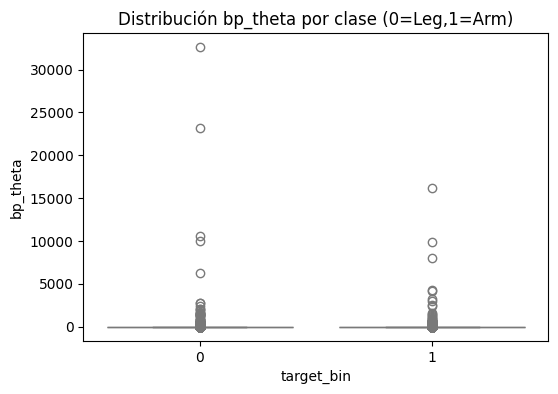

C:\Users\loper\AppData\Local\Temp\ipykernel_4392\1918687650.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["target_bin"], y=df[col], palette="coolwarm")


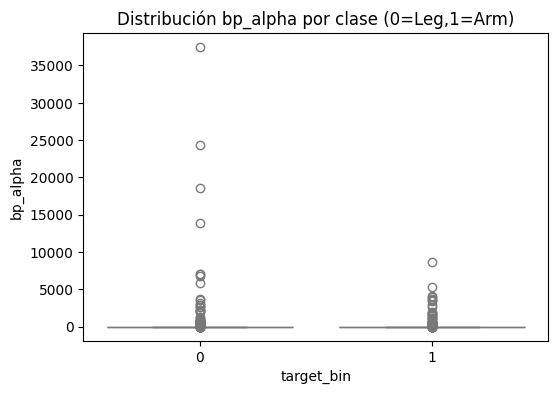

C:\Users\loper\AppData\Local\Temp\ipykernel_4392\1918687650.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["target_bin"], y=df[col], palette="coolwarm")


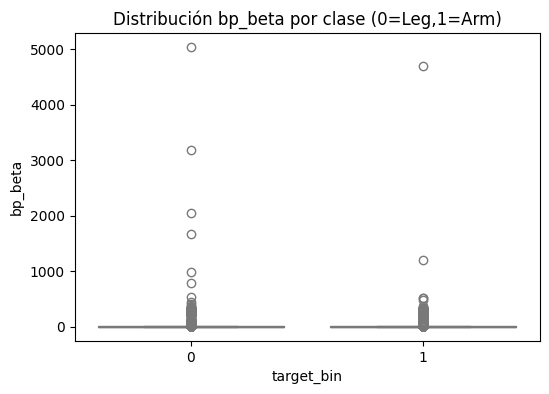

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

bp_cols = ["bp_delta", "bp_theta", "bp_alpha", "bp_beta"]

for col in bp_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df["target_bin"], y=df[col], palette="coolwarm")
    plt.title(f"Distribución {col} por clase (0=Leg,1=Arm)")
    plt.show()


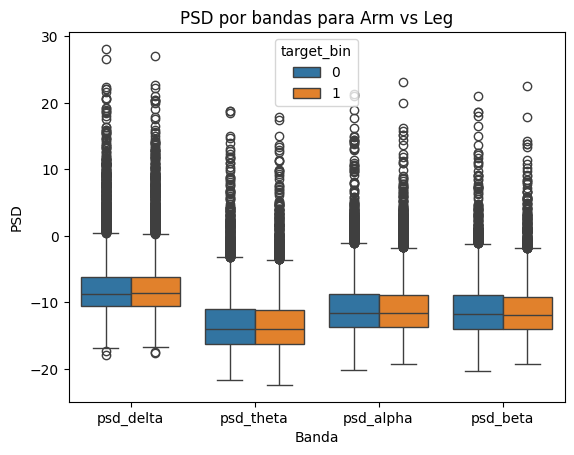

In [93]:
psd_cols = ["psd_delta", "psd_theta", "psd_alpha", "psd_beta"]

df_long = df.melt(id_vars="target_bin", value_vars=psd_cols,
                  var_name="Banda", value_name="PSD")

sns.boxplot(data=df_long, x="Banda", y="PSD", hue="target_bin")
plt.title("PSD por bandas para Arm vs Leg")
plt.show()


In [105]:
def rename_and_set_montage(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    """Renombra EEG0..EEG7 a Fz,C3,Cz,C4,Pz,PO7,PO8,Oz y asigna montage estándar."""
    CHAN_MAP = {
        "EEG0": "Fz",
        "EEG1": "C3",
        "EEG2": "Cz",
        "EEG3": "C4",
        "EEG4": "Pz",
        "EEG5": "PO7",
        "EEG6": "PO8",
        "EEG7": "Oz",
    }

    # Renombrar canales
    mapping = {old: new for old, new in CHAN_MAP.items() if old in raw.info["ch_names"]}
    raw = raw.copy().rename_channels(mapping)

    # Cargar montaje 10-20
    montage = mne.channels.make_standard_montage("standard_1020")

    # Asignar montaje
    raw.set_montage(montage, match_case=False)

    print("\nCanales después de renombrar:", raw.info["ch_names"])
    print("Montage:", raw.get_montage())

    return raw


In [103]:
raw = load_raw_file(Path("C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025/Female/10/AW/AW_S010_1.xdf"))
raw = rename_and_set_montage(raw)


   [XDF] Cargando con pyxdf: C:\Users\loper\ITM\automatización\auto 2\BCI\OneDrive_1_18-10-2025\Female\10\AW\AW_S010_1.xdf
   [XDF] sampling_rate NO encontrado, calculando desde timestamps...
   [XDF] sampling_rate estimado: 249.90 Hz
Creating RawArray with float64 data, n_channels=8, n_times=102831
    Range : 0 ... 102830 =      0.000 ...   411.492 secs
Ready.
   [XDF] Loaded: 8 canales, sfreq=249.90 Hz


Canales después de renombrar: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'PO8', 'Oz']
Montage: <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 8 channels>


In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

knn_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=5))  # k=5
])


In [110]:
knn_clf.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

Accuracy KNN: 0.524822695035461
              precision    recall  f1-score   support

           0       0.52      0.53      0.53       564
           1       0.53      0.52      0.52       564

    accuracy                           0.52      1128
   macro avg       0.52      0.52      0.52      1128
weighted avg       0.52      0.52      0.52      1128



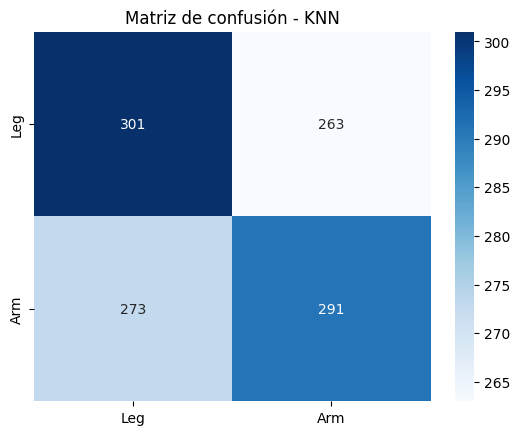

In [111]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = knn_clf.predict(X_test)

print("Accuracy KNN:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=["Leg","Arm"], yticklabels=["Leg","Arm"])
plt.title("Matriz de confusión - KNN")
plt.show()


   [XDF] Cargando con pyxdf: C:\Users\loper\ITM\automatización\auto 2\BCI\OneDrive_1_18-10-2025\Female\10\AW\AW_S010_1.xdf
   [XDF] sampling_rate NO encontrado, calculando desde timestamps...
   [XDF] sampling_rate estimado: 249.90 Hz
Creating RawArray with float64 data, n_channels=8, n_times=102831
    Range : 0 ... 102830 =      0.000 ...   411.492 secs
Ready.
   [XDF] Loaded: 8 canales, sfreq=249.90 Hz


Canales después de renombrar: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'PO8', 'Oz']
Montage: <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 8 channels>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passban

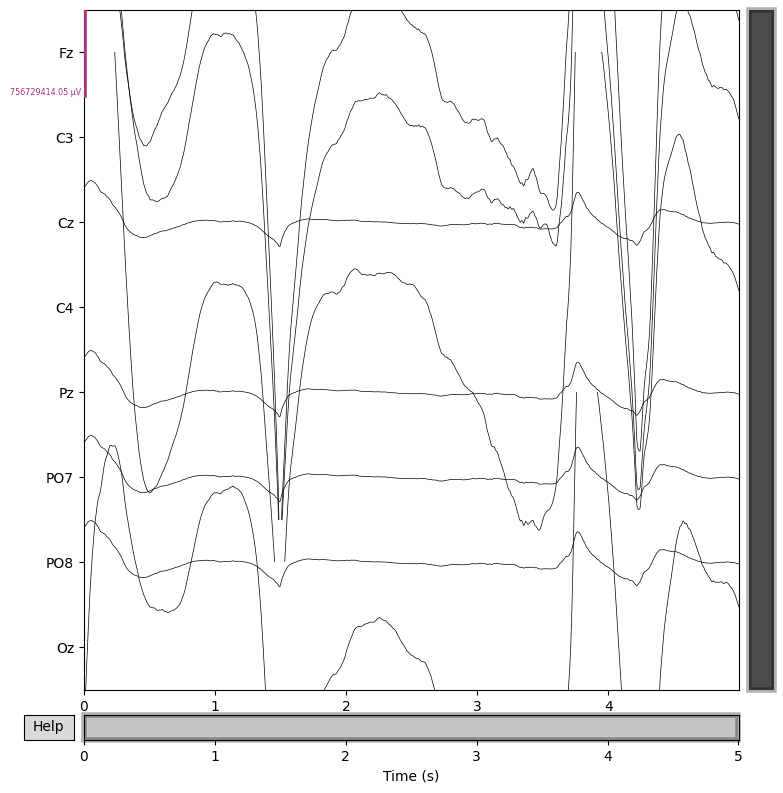

Text(0.5, 1.03, 'Señal AW-BP mujer 10')

In [121]:
from pathlib import Path

# 1. Cargar un archivo (por ejemplo MI de un sujeto)
raw = load_raw_file(Path("C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025/Female/10/AW/AW_S010_1.xdf"))

# 2. Renombrar canales y poner montaje (la función que ya hicimos)
raw = rename_and_set_montage(raw)

# 3. Filtro general para que se vea bonito (1–40 Hz)
raw_filt = raw.copy().filter(1., 40., fir_design="firwin")

# 4. Recortar un pedazo de 5 segundos para visualizar
raw_crop = raw_filt.copy().crop(tmin=10.0, tmax=15.0)  # cambia los tiempos si quieres

# 5. Mostrar las ondas de TODOS los canales al tiempo
fig = raw_crop.plot(n_channels=8, scalings="auto")
fig.suptitle("Señal AW-BP mujer 10", fontsize=16, y=1.03)


   [XDF] Cargando con pyxdf: C:\Users\loper\ITM\automatización\auto 2\BCI\OneDrive_1_18-10-2025\Female\10\MO\MO_S010_1.xdf
   [XDF] sampling_rate NO encontrado, calculando desde timestamps...
   [XDF] sampling_rate estimado: 249.78 Hz
Creating RawArray with float64 data, n_channels=8, n_times=92921
    Range : 0 ... 92920 =      0.000 ...   372.001 secs
Ready.
   [XDF] Loaded: 8 canales, sfreq=249.78 Hz


Canales después de renombrar: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'PO8', 'Oz']
Montage: <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 8 channels>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband 

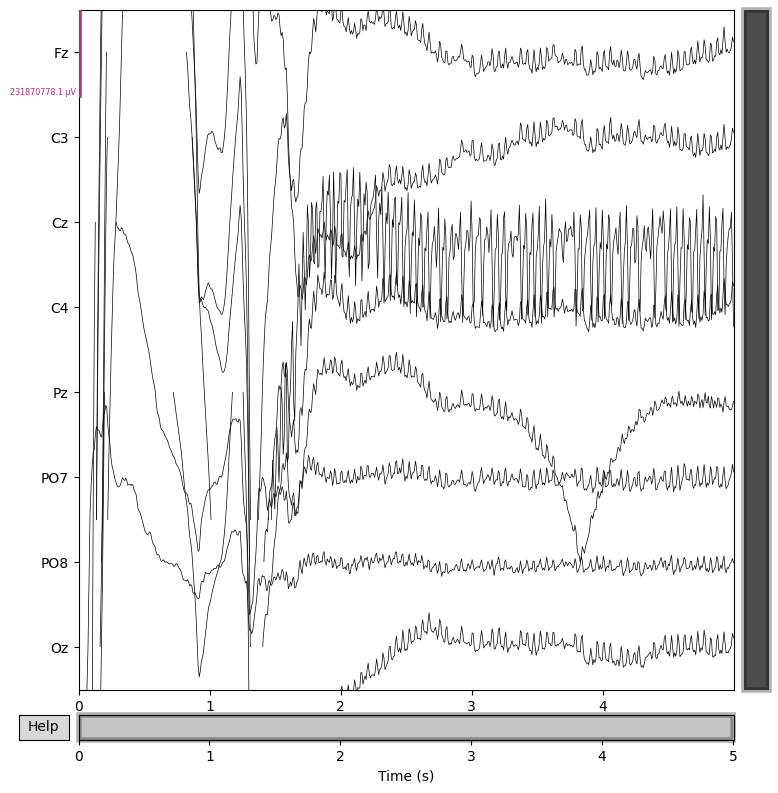

Text(0.5, 1.03, 'Señal MO-BP mujer 10')

In [122]:
from pathlib import Path

# 1. Cargar un archivo (por ejemplo MI de un sujeto)
raw = load_raw_file(Path("C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025/Female/10/MO/MO_S010_1.xdf"))

# 2. Renombrar canales y poner montaje (la función que ya hicimos)
raw = rename_and_set_montage(raw)

# 3. Filtro general para que se vea bonito (1–40 Hz)
raw_filt = raw.copy().filter(1., 40., fir_design="firwin")

# 4. Recortar un pedazo de 5 segundos para visualizar
raw_crop = raw_filt.copy().crop(tmin=10.0, tmax=15.0)  # cambia los tiempos si quieres

# 5. Mostrar las ondas de TODOS los canales al tiempo
fig = raw_crop.plot(n_channels=8, scalings="auto")
fig.suptitle("Señal MO-BP mujer 10", fontsize=16, y=1.03)


   [XDF] Cargando con pyxdf: C:\Users\loper\ITM\automatización\auto 2\BCI\OneDrive_1_18-10-2025\Female\10\MI\MI_S010_1.xdf
   [XDF] sampling_rate NO encontrado, calculando desde timestamps...
   [XDF] sampling_rate estimado: 249.80 Hz
Creating RawArray with float64 data, n_channels=8, n_times=102667
    Range : 0 ... 102666 =      0.000 ...   410.993 secs
Ready.
   [XDF] Loaded: 8 canales, sfreq=249.80 Hz


Canales después de renombrar: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'PO8', 'Oz']
Montage: <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 8 channels>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passban

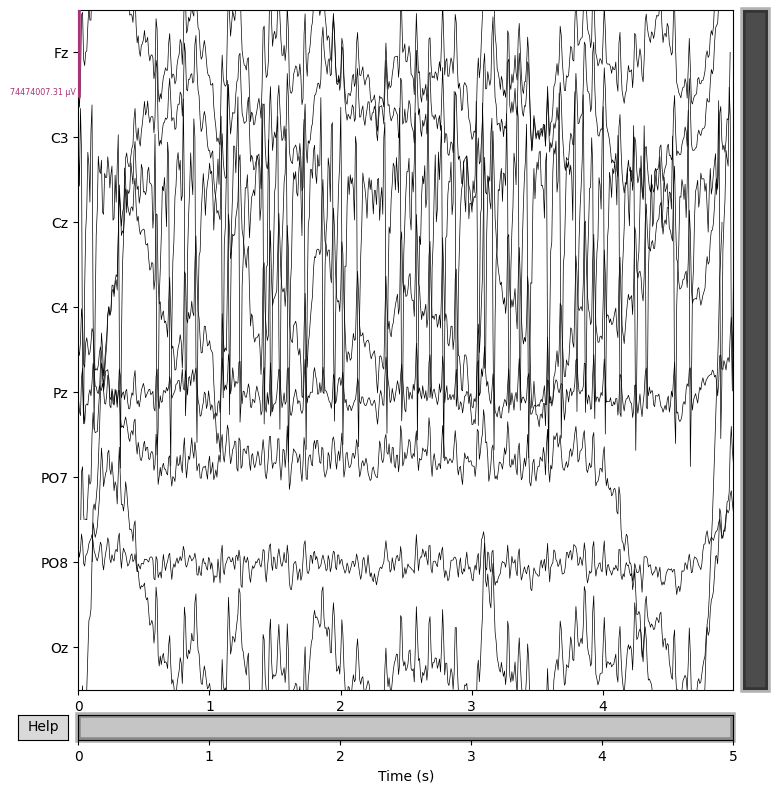

Text(0.5, 1.03, 'Señal MI-BP mujer 10')

In [123]:
from pathlib import Path

# 1. Cargar un archivo (por ejemplo MI de un sujeto)
raw = load_raw_file(Path("C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025/Female/10/MI/MI_S010_1.xdf"))

# 2. Renombrar canales y poner montaje (la función que ya hicimos)
raw = rename_and_set_montage(raw)

# 3. Filtro general para que se vea bonito (1–40 Hz)
raw_filt = raw.copy().filter(1., 40., fir_design="firwin")

# 4. Recortar un pedazo de 5 segundos para visualizar
raw_crop = raw_filt.copy().crop(tmin=10.0, tmax=15.0)  # cambia los tiempos si quieres

# 5. Mostrar las ondas de TODOS los canales al tiempo
fig = raw_crop.plot(n_channels=8, scalings="auto")
fig.suptitle("Señal MI-BP mujer 10", fontsize=16, y=1.03)


   [XDF] Cargando con pyxdf: C:\Users\loper\ITM\automatización\auto 2\BCI\OneDrive_1_18-10-2025\Female\10\AW\AW_S010_1.xdf
   [XDF] sampling_rate NO encontrado, calculando desde timestamps...
   [XDF] sampling_rate estimado: 249.90 Hz
Creating RawArray with float64 data, n_channels=8, n_times=102831
    Range : 0 ... 102830 =      0.000 ...   411.492 secs
Ready.
   [XDF] Loaded: 8 canales, sfreq=249.90 Hz


Canales después de renombrar: ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'PO7', 'PO8', 'Oz']
Montage: <DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 8 channels>
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband

C:\Users\loper\AppData\Local\Temp\ipykernel_4392\4009782770.py:15: RuntimeWarning: filter_length (825) is longer than the signal (501), distortion is likely. Reduce filter length or filter a longer signal.
  tmp = raw_in.copy().filter(l_freq, h_freq, fir_design="firwin")


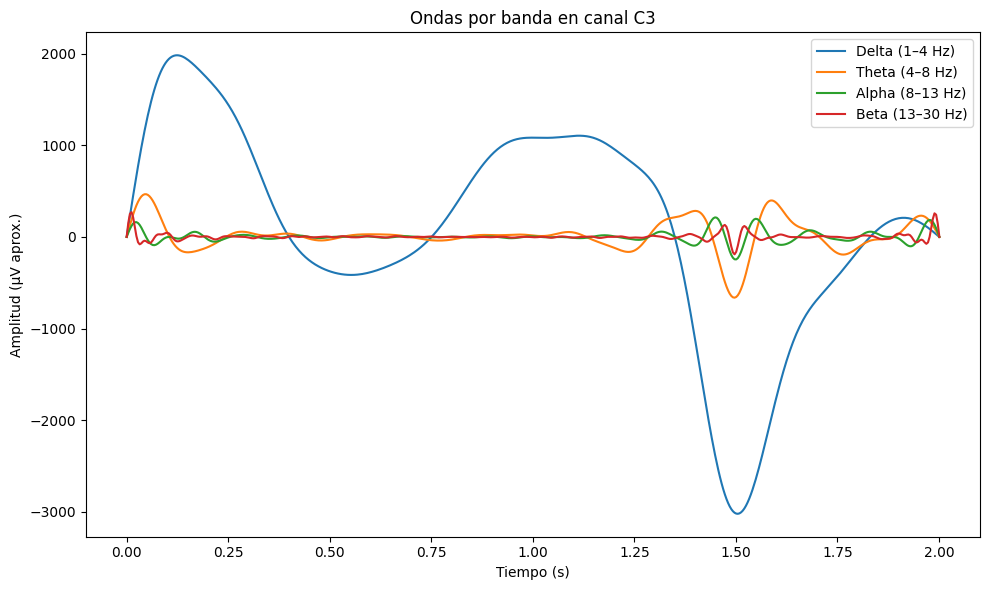

In [116]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que ya tienes raw_filt como antes
raw = load_raw_file(Path("C:/Users/loper/ITM/automatización/auto 2/BCI/OneDrive_1_18-10-2025/Female/10/AW/AW_S010_1.xdf"))
raw = rename_and_set_montage(raw)

# Tomamos solo el canal C3
sfreq = raw.info["sfreq"]
tmin, tmax = 10.0, 12.0  # ventana de 2 segundos
raw_crop = raw.copy().crop(tmin=tmin, tmax=tmax)

# Función auxiliar para obtener señal filtrada de un canal
def get_band(raw_in, ch_name, l_freq, h_freq):
    tmp = raw_in.copy().filter(l_freq, h_freq, fir_design="firwin")
    data = tmp.get_data(picks=[ch_name])[0]  # (n_times,)
    return data

times = raw_crop.times  # eje de tiempo en segundos

delta = get_band(raw_crop, "C3", 1., 4.)
theta = get_band(raw_crop, "C3", 4., 8.)
alpha = get_band(raw_crop, "C3", 8., 13.)
beta  = get_band(raw_crop, "C3", 13., 30.)

plt.figure(figsize=(10,6))
plt.plot(times, delta, label="Delta (1–4 Hz)")
plt.plot(times, theta, label="Theta (4–8 Hz)")
plt.plot(times, alpha, label="Alpha (8–13 Hz)")
plt.plot(times, beta,  label="Beta (13–30 Hz)")
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud (µV aprox.)")
plt.title("Ondas por banda en canal C3")
plt.legend()
plt.tight_layout()
plt.show()
